In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nazar/nazar.jpg
/kaggle/input/human-faces-object-detection/faces.csv
/kaggle/input/human-faces-object-detection/images/00002129.jpg


In [2]:
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib import patches
import tensorflow as tf
from PIL import Image
from tensorflow.keras.applications import InceptionResNetV2

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
boxes = pd.read_csv('/kaggle/input/human-faces-object-detection/faces.csv')
boxes.set_index("image_name", inplace=True)
boxes.head()

,width,height,x0,y0,x1,y1
image_name,,,,,,
00001722.jpg,1333,2000,490,320,687,664
00001044.jpg,2000,1333,791,119,1200,436
00001050.jpg,667,1000,304,155,407,331
00001736.jpg,626,417,147,14,519,303
00003121.jpg,626,418,462,60,599,166


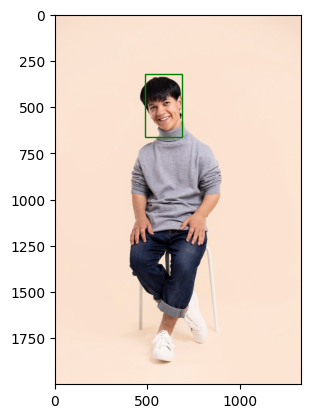

In [4]:
images_dir = '/kaggle/input/human-faces-object-detection/images/'
image_name = "00001722.jpg"
box_x, box_y = boxes.loc[image_name].x0, boxes.loc[image_name].y0
box_width, box_height = boxes.loc[image_name].x1 - box_x, boxes.loc[image_name].y1 - box_y

image = cv.imread(images_dir + image_name)[..., ::-1]# cv.imread returns in brg format, not rgb

plt.imshow(image)
plt.gca().add_patch(patches.Rectangle((box_x, box_y), box_width, box_height, 
                                      edgecolor="g", facecolor = "none"))

## All images need to be reshaped to the same shape, so are boxes

In [5]:
reshaped_size = 256
max_number_of_faces = 6

In [6]:
boxes.x0 = (boxes.x0 / boxes.width * reshaped_size).astype(int)
boxes.x1 = (boxes.x1 / boxes.width * reshaped_size).astype(int)
boxes.y0 = (boxes.y0 / boxes.height * reshaped_size).astype(int)
boxes.y1 = (boxes.y1 / boxes.height * reshaped_size).astype(int)
boxes = boxes.drop(["width", "height"], axis=1)

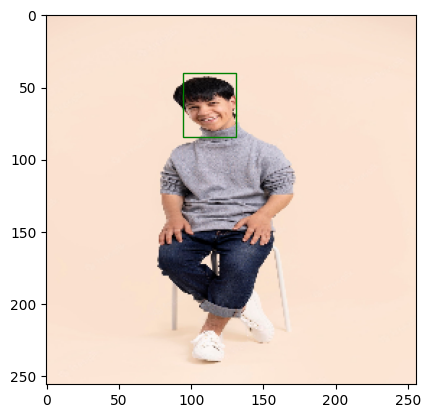

In [7]:
box_x, box_y = boxes.loc[image_name].x0, boxes.loc[image_name].y0
box_width, box_height = boxes.loc[image_name].x1 - box_x, boxes.loc[image_name].y1 - box_y
plt.imshow(cv.resize(image, (reshaped_size, reshaped_size)))
plt.gca().add_patch(patches.Rectangle((box_x, box_y), box_width, box_height, 
                                      edgecolor="g", facecolor = "none"))

In [8]:
def load_image_and_boxes(path):
    # loads image and box for this image from given path
    # also normalizes image and box coords
    image = cv.imread(path.decode('utf-8'))[..., ::-1]
    image = cv.resize(image, (reshaped_size, reshaped_size)) / 255.0
    label = boxes.loc[path.decode('utf-8').split("/")[-1]].values / 255.0
    n_of_faces = label.shape[0] if len(label.shape) > 1 else 1
    if n_of_faces > max_number_of_faces:
        label = label[:max_number_of_faces].flatten()
    else:
        label = np.hstack([
            label.flatten(), 
            np.zeros((max_number_of_faces - n_of_faces) * 4)
        ])
    label = np.hstack([[min(n_of_faces, max_number_of_faces) / max_number_of_faces], label])  # number of faces in image
    return [image.astype(np.float32), label.astype(np.float32)]

In [9]:
images_path = [os.path.join(images_dir, f) for f in os.listdir(images_dir)]

ds = tf.data.Dataset.from_tensor_slices(images_path)
ds = ds.map(lambda x: tf.numpy_function(load_image_and_boxes, [x], [np.float32, np.float32]))

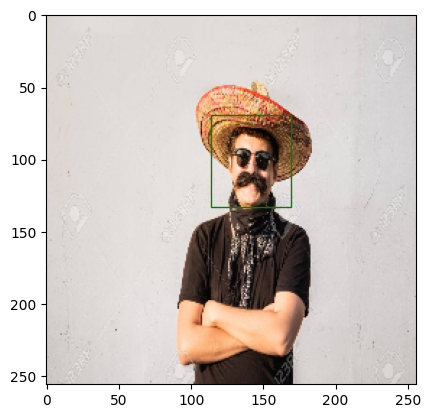

In [10]:
for i in ds.take(1):
    plt.imshow(i[0])
    box = i[1][1:] * 255
    plt.gca().add_patch(patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], 
                                      edgecolor="g", facecolor = "none"))

### Fourier Transformation

In [14]:
def distance(point1,point2):
    return np.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)

def idealFilterLP(D0,imgShape):
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            if distance((y,x),center) < D0:
                base[y,x] = 1
    return base

def idealFilterHP(D0,imgShape):
    base = np.ones(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            if distance((y,x),center) < D0:
                base[y,x] = 0
    return base

def low_pass_fourier_color(img):
    channels = cv.split(img)  # Split into individual channels
    processed_channels = []

    for channel in channels:
        original = np.fft.fft2(channel)
        center = np.fft.fftshift(original)
        low_pass_center = center * idealFilterLP(50, channel.shape)
        low_pass = np.fft.ifftshift(low_pass_center)
        inverse_low_pass = np.fft.ifft2(low_pass)
        processed_channel = np.abs(inverse_low_pass)
        processed_channels.append(processed_channel)

    processed_image = np.stack(processed_channels, axis=-1)
    processed_image = (processed_image - np.min(processed_image)) / (np.max(processed_image) - np.min(processed_image))

    return processed_image

### Blur

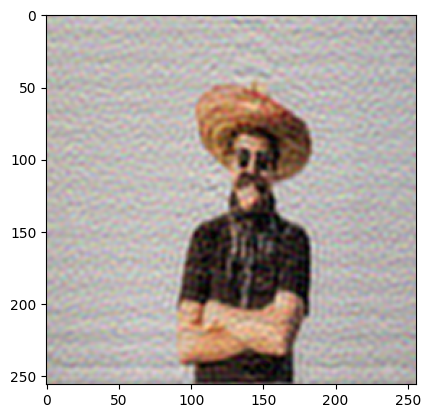

In [17]:
def add_gaussian_noise(image, mean=0.008, std_dev=0.008):
    noisy_image = np.copy(image)
    h, w, _ = noisy_image.shape
    noise = np.random.normal(mean, std_dev, (h, w, 3))
    noisy_image = noisy_image + noise
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.float32)
    
    return noisy_image


def perform_svd(blurred_channel, blur_matrix, rank=80):
    U, S, V = np.linalg.svd(blur_matrix)
    
    U = U[:, :rank]
    S = S[:rank]
    V = V[:rank, :]
    
    S = np.linalg.pinv(np.diag(S))

    A = V.T @ S @ U.T
    
    return A @ blurred_channel


def generate_blur_matrix(kernel_size, sigma):
    kernel = np.fromfunction(lambda x, y: (1/(2*np.pi*sigma**2)) * np.exp(-((x-kernel_size//2)**2 + (y-kernel_size//2)**2)/(2*sigma**2)), (kernel_size, kernel_size))
    kernel /= np.sum(kernel)
    kernel = tf.reshape(tf.constant(kernel, dtype=tf.float32), (kernel_size, kernel_size, 1, 1))
    blur_matrix = tf.nn.depthwise_conv2d(tf.expand_dims(tf.expand_dims(tf.eye(256), axis=-1), axis=-1), kernel, strides=[1, 1, 1, 1], padding='SAME')
    
    return blur_matrix

def preprocess_deblured(image):
    blur_matrix = generate_blur_matrix(20, 8.0)[:, :, 0, 0]

    blured = np.stack([blur_matrix @ image[..., 0], blur_matrix @ image[..., 1], blur_matrix @ image[..., 2]], 2)
    blured /= blured.max()
    
    blured = add_gaussian_noise(blured)
    
    reconstructed_channel_0 = perform_svd(blured[:, :, 0], blur_matrix)
    reconstructed_channel_1 = perform_svd(blured[:, :, 1], blur_matrix)
    reconstructed_channel_2 = perform_svd(blured[:, :, 2], blur_matrix)
    
    reconstructed_image = np.stack([reconstructed_channel_0, reconstructed_channel_1, reconstructed_channel_2], 2)
    
    reconstructed_image = low_pass_fourier_color(reconstructed_image)
    return reconstructed_image.astype(np.float32)

for i in ds.take(1):
    x = np.array(i[0], dtype=np.float32)    
    plt.imshow(preprocess_deblured(reconstructed_image))

In [18]:
def preprocess(image, labels):
    return preprocess_deblured(image), labels

ds = ds.map(lambda x, y: tf.numpy_function(preprocess, [x, y], [np.float32, np.float32]))

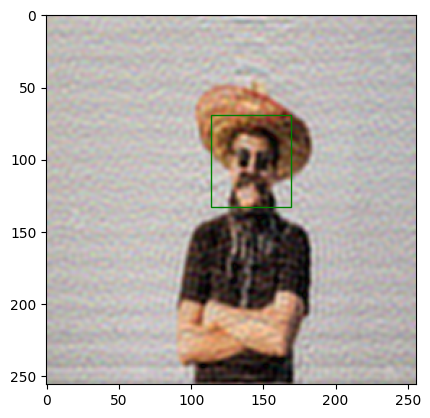

In [19]:
for i in ds.take(1):
    plt.imshow(i[0])
    box = i[1][1:] * 255
    plt.gca().add_patch(patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], 
                                      edgecolor="g", facecolor = "none"))

## Model

In [ ]:
resnet = InceptionResNetV2(weights="imagenet",include_top=False, 
                           input_tensor=tf.keras.layers.Input(shape=(reshaped_size,reshaped_size,3)))

In [ ]:
model_top = resnet.output
model_top = tf.keras.layers.Flatten()(model_top)
model_top = tf.keras.layers.Dense(500,activation="relu")(model_top)
model_top = tf.keras.layers.Dense(250,activation="relu")(model_top)
model_top = tf.keras.layers.Dense(4 * max_number_of_faces + 1,activation='sigmoid')(model_top)

model = tf.keras.models.Model(inputs=resnet.input,outputs=model_top)

In [ ]:
def iou(box_true, box_pred):
    n_of_boxes = tf.round(box_true[:, 0] * max_number_of_faces)
    bb1, bb2 = box_true[:, 1:], box_pred[:, 1:]
    # Intersection over Union
    score = 0
    for i in range(max_number_of_faces):
        x_left = tf.maximum(bb1[:, 4*i], bb2[:, 4*i])
        y_top = tf.maximum(bb1[:, 4*i+1], bb2[:, 4*i+1])
        x_right = tf.minimum(bb1[:, 4*i+2], bb2[:, 4*i+2])
        y_bottom = tf.minimum(bb1[:, 4*i+3], bb2[:, 4*i+3])

        intersection_area = tf.maximum(x_right - x_left, 0) * tf.maximum(y_bottom - y_top, 0)
        bb1_area = (bb1[:, 4*i+2] - bb1[:, 4*i]) * (bb1[:, 4*i+3] - bb1[:, 4*i+1])
        bb2_area = (bb2[:, 4*i+2] - bb2[:, 4*i]) * (bb2[:, 4*i+3] - bb2[:, 4*i+1])
        score += (intersection_area / (bb1_area + bb2_area - intersection_area)) * tf.clip_by_value(tf.sign(n_of_boxes - i), clip_value_min=0.0, clip_value_max=tf.float32.max)

    return tf.reduce_mean(score / tf.clip_by_value(n_of_boxes, clip_value_min=0.0, clip_value_max=tf.float32.max))

### Firstly, freeze all pretrained layers and train only new one, that we added

In [ ]:
for layer in model.layers[:-3]:
    layer.trainble = False
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

In [ ]:
history = model.fit(ds.batch(10).prefetch(1), epochs=10)

### Now unfreeze all layers an train model

In [ ]:
for layer in model.layers:
    layer.trainble = True
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=[iou])

In [ ]:
history = model.fit(ds.batch(10).prefetch(1), epochs=10)

In [ ]:
def draw_image_with_box(image, box1, box2 = None):
    """
    draws image and box on it.
    if function receives two boxes, meaning that one is true, and other is predicted,
    it will label image with intersection over union score
    """
    plt.imshow(image)
    plt.axis("off")
    n_of_boxes = int(tf.round(box1[0] * max_number_of_faces).numpy())
    box1_coords = box1[1:] * 255
    for i in range(n_of_boxes):
        plt.gca().add_patch(patches.Rectangle((box1_coords[4*i], box1_coords[4*i+1]), 
                                              box1_coords[4*i+2]-box1_coords[4*i], 
                                              box1_coords[4*i+3]-box1_coords[4*i+1], 
                                              edgecolor="g", facecolor = "none", linewidth=2))
    if box2 is not None:
        box2_coords =  box2[1:] * 255
        n_of_boxes = int(tf.round(box2[0] * max_number_of_faces).numpy())
        for i in range(n_of_boxes):
            plt.gca().add_patch(patches.Rectangle((box2_coords[4*i], box2_coords[4*i+1]), 
                                              box2_coords[4*i+2]-box2_coords[4*i], 
                                              box2_coords[4*i+3]-box2_coords[4*i+1], 
                                              edgecolor="r", facecolor = "none", linewidth=2))
        
        plt.title("Intersection over Union: " + 
                  str(iou(box1[np.newaxis, ...], box2[np.newaxis, ...]).numpy()), fontsize=10)

In [ ]:
n_examples = 10

images = next(iter(ds.shuffle(buffer_size=100).batch(n_examples)))
box_predicted = model(images[0])
plt.figure(figsize=(10, 30))
for i in range(n_examples):
    plt.subplot(n_examples, 2, i+1)
    draw_image_with_box(images[0][i], images[1][i], box_predicted[i])
#     print(iou(box_predicted[i][np.newaxis, ...], images[1][i][np.newaxis, ...]))

In [ ]:
path = "/kaggle/input/nazar/nazar.jpg"
image = cv.imread(path)[..., ::-1]
image = cv.resize(image, (reshaped_size, reshaped_size)) / 255.0

image = image.reshape(1, reshaped_size, reshaped_size, 3)
box = model(image)
draw_image_with_box(image[0], box[0])